In [12]:
# Optional: uncomment these lines if you run in Google Colab and store data on Drive.
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/my-drive/Colab Notebooks/NLP/toast-roast-dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import matplotlib.pyplot as plt

import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

import pandas as pd

import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# Functions

In [14]:
# Graph to plot history

def f_plot_history( history, file_to_save ):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 5),  constrained_layout=True)

  # plot accuracy subplot
  ax = axes[0]
  ax.plot(epochs, acc, 'b--', label='Training acc')
  ax.plot(epochs, val_acc, 'r-o', label='Validation acc')
  ax.set_title('Training and validation accuracy')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Accuracy')
  ax.legend()
  ax.grid()
  #ax.set_ylim(0,1)
  ax.legend()

  # plot loss subplot
  ax = axes[1]
  ax.plot(epochs, loss, 'b--', label='Training loss')
  ax.plot(epochs, val_loss, 'r-o', label='Validation loss')
  ax.set_title('Training and validation loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()
  ax.grid()
  ax.legend()

  plt.savefig( file_to_save, dpi=400 )
  plt.show()


  return plt


def f_create_dir( pathOut ):
    if not os.path.exists( pathOut ):
        os.makedirs( pathOut )

# Settings

In [15]:
ExpID = "PPv1"

num_epochs = 10

pathIn_main = Path("/content/drive/My Drive/Colab Notebooks/NLP/toast-roast-dataset")

fileIn_Train_Toast = pathIn_main / "Train__Toast.xlsx"
fileIn_Train_Roast = pathIn_main / "Train__Roast.xlsx"

fileIn_Val_Toast = pathIn_main / "Val__Toast.xlsx"
fileIn_Val_Roast = pathIn_main / "Val__Roast.xlsx"

fileIn_Test_Toast = pathIn_main / "Test__Toast.xlsx"
fileIn_Test_Roast = pathIn_main / "Test__Roast.xlsx"

pathSave_main_Results = Path("results") / ExpID
f_create_dir(pathSave_main_Results)

pathSave_trained_models = Path("/content/drive/My Drive/Colab Notebooks/NLP/toast-roast-dataset/TrainedModels - Dataset 1") / ExpID
f_create_dir(pathSave_trained_models)


In [16]:
df_Train_Toast = pd.read_excel( fileIn_Train_Toast, index_col=None )
df_Train_Toast.dropna( inplace=True )

df_Train_Roast = pd.read_excel( fileIn_Train_Roast, index_col=None )
df_Train_Roast.dropna( inplace=True )

df_Val_Toast = pd.read_excel( fileIn_Val_Toast, index_col=None )
df_Val_Toast.dropna( inplace=True )

df_Val_Roast = pd.read_excel( fileIn_Val_Roast, index_col=None )
df_Val_Roast.dropna( inplace=True )

df_Test_Toast = pd.read_excel( fileIn_Test_Toast, index_col=None )
df_Test_Toast.dropna( inplace=True )

df_Test_Roast = pd.read_excel( fileIn_Test_Roast, index_col=None )
df_Test_Roast.dropna( inplace=True )

In [17]:
text_Train = df_Train_Toast["text_PP"].tolist() + df_Train_Roast["text_PP"].tolist()
Labs_Train = np.hstack( [np.zeros(df_Train_Toast["text_PP"].shape[0]), np.ones(df_Train_Roast["text_PP"].shape[0])] )

text_Val = df_Val_Toast["text_PP"].tolist() + df_Val_Roast["text_PP"].tolist()
Labs_Val = np.hstack( [np.zeros(df_Val_Toast["text_PP"].shape[0]), np.ones(df_Val_Roast["text_PP"].shape[0])] )

text_Test = df_Test_Toast["text_PP"].tolist() + df_Test_Roast["text_PP"].tolist()
Labs_Test = np.hstack( [np.zeros(df_Test_Toast["text_PP"].shape[0]), np.ones(df_Test_Roast["text_PP"].shape[0])] )


Labs_Train_cat = to_categorical( Labs_Train, num_classes=2 ).astype("float32")
Labs_Val_cat = to_categorical( Labs_Val, num_classes=2 ).astype("float32")
Labs_Test_cat = to_categorical( Labs_Test, num_classes=2 ).astype("float32")


In [18]:
print( len(text_Train), len(text_Val), len(text_Test) )

print( sum(Labs_Train)/len(text_Train), sum(Labs_Val)/len(text_Val), sum(Labs_Test)/len(text_Test) )

104509 12654 2000
0.5848587203016008 0.47400031610557924 0.5005


# TF-IDF + Linear SVM Classifier

In [19]:
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000)

Feats_Train = vectorizer.fit_transform(text_Train)
Feats_Val = vectorizer.transform( text_Val )
Feats_Test = vectorizer.transform( text_Test )

print( Feats_Train.shape, Feats_Val.shape, Feats_Test.shape )

LinearSVC_clf = LinearSVC(C=1e-5, class_weight="balanced", max_iter=1000, random_state=0)

LinearSVC_clf.fit(Feats_Train, Labs_Train)

predLabs_Val =  LinearSVC_clf.predict(Feats_Val)
acc_Val = sklearn.metrics.accuracy_score(Labs_Val, predLabs_Val)

predLabs_Test = LinearSVC_clf.predict(Feats_Test)
acc_Test = sklearn.metrics.accuracy_score(Labs_Test, predLabs_Test)

print( acc_Val, acc_Test )

(104509, 10000) (12654, 10000) (2000, 10000)
0.8309625414888573 0.8255


In [20]:
Labs_Val.shape

(12654,)

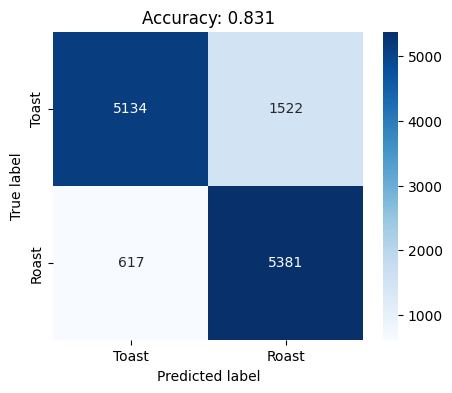




              precision    recall  f1-score   support

       Toast       0.89      0.77      0.83      6656
       Roast       0.78      0.90      0.83      5998

    accuracy                           0.83     12654
   macro avg       0.84      0.83      0.83     12654
weighted avg       0.84      0.83      0.83     12654



In [29]:
#### Confusion matrix and classifier report for Val
cm = confusion_matrix(Labs_Val, predLabs_Val)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["Toast", "Roast"],
                     columns = ["Toast", "Roast"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Accuracy: {0:.3f}'.format(accuracy_score(Labs_Val, predLabs_Val)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(
    pathSave_main_Results / f"ConfMat_Val_TFIDF__{ExpID}.png",
    dpi=400
)
plt.show()

print("\n\n")
print(classification_report(Labs_Val, predLabs_Val, target_names=["Toast", "Roast"]))

In [30]:
predLabs_Test.shape

(2000,)

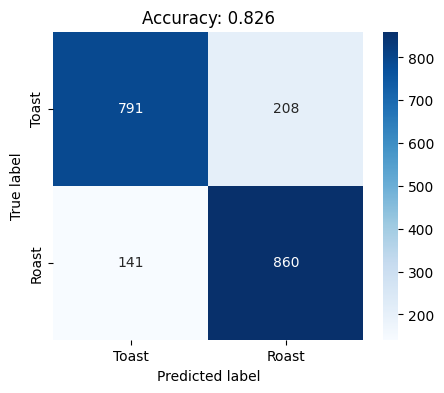




              precision    recall  f1-score   support

       Toast       0.85      0.79      0.82       999
       Roast       0.81      0.86      0.83      1001

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [31]:
#### Confusion matrix and classifier report for Test
cm = confusion_matrix(Labs_Test, predLabs_Test)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["Toast", "Roast"],
                     columns = ["Toast", "Roast"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Accuracy: {0:.3f}'.format(accuracy_score(Labs_Test, predLabs_Test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(
    str(pathSave_main_Results) + "/ConfMat_Val_TFIDF__" + ExpID + ".png",
    dpi=400
)
plt.show()

print("\n\n")
print(classification_report(Labs_Test, predLabs_Test, target_names=["Toast", "Roast"]))

# Keras Tokenize

In [32]:
# Define the maximum number of words to keep in the vocabulary
vocabulary_size = 10000

# Define the maximum length of the input sequences
max_length = 300

# Create a tokenizer object and fit it on the training data
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(text_Train)

# Convert the text data to sequences of integers
sequences_Train = tokenizer.texts_to_sequences(text_Train)
sequences_Val = tokenizer.texts_to_sequences(text_Val)
sequences_Test = tokenizer.texts_to_sequences(text_Test)



# Pad the sequences to a fixed length using the pad_sequences function
padded_Train = pad_sequences(sequences_Train, maxlen=max_length)
padded_Val = pad_sequences(sequences_Val, maxlen=max_length)
padded_Test = pad_sequences(sequences_Test, maxlen=max_length)

# Verify the shape of the padded sequences
print("Shape of padded_Train:", padded_Train.shape)
print("Shape of padded_Val:", padded_Val.shape)
print("Shape of padded_Test:", padded_Test.shape)

Shape of padded_Train: (104509, 300)
Shape of padded_Val: (12654, 300)
Shape of padded_Test: (2000, 300)


# Custom Embedding with Dense

In [27]:
# Define the size of the vocabulary, which will be used to encode the text

modelname = "KerasEmbDense"

input_shape = (padded_Train.shape[1],)

# Define the model architecture
model = Sequential()

# Add an Embedding layer to the model, which will learn a dense vector representation of the words
# The input_dim parameter should be set to the size of the vocabulary
# The output_dim parameter specifies the size of the dense vector representation
# The input_length parameter should be set to the maximum length of the input sequences
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_shape=input_shape ))

# Add a Flatten layer to the model, which will flatten the output of the Embedding layer into a 1D vector
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
model_checkpoint = ModelCheckpoint(
    pathSave_trained_models / f"{modelname}_best_model_{{val_accuracy:.4f}}.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)



# Train the model
history = model.fit(padded_Train, Labs_Train_cat, epochs=num_epochs, batch_size=32, validation_data=(padded_Val, Labs_Val_cat), callbacks=[early_stop, model_checkpoint])

# Load the saved best model
model = load_model(
    pathSave_trained_models / f"{modelname}_best_model_{model_checkpoint.best:.4f}.h5"
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(padded_Test, Labs_Test_cat)
print('Test accuracy:', test_acc)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(padded_Test, Labs_Test_cat)
print('Test accuracy:', test_acc)

Epoch 1/10
3265/3266 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8321 - loss: 0.3473
Epoch 1: val_accuracy improved from -inf to 0.92050, saving model to trained_models/PPv1/KerasEmbDense_best_model_0.9205.h5


3266/3266 ━━━━━━━━━━━━━━━━━━━━ 76s 22ms/step - accuracy: 0.8321 - loss: 0.3473 - val_accuracy: 0.9205 - val_loss: 0.1948
Epoch 2/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9399 - loss: 0.1650
Epoch 2: val_accuracy improved from 0.92050 to 0.92840, saving model to trained_models/PPv1/KerasEmbDense_best_model_0.9284.h5


3266/3266 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.9399 - loss: 0.1650 - val_accuracy: 0.9284 - val_loss: 0.1898
Epoch 3/10
3265/3266 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9522 - loss: 0.1304
Epoch 3: val_accuracy did not improve from 0.92840
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.9522 - loss: 0.1304 - val_accuracy: 0.9272 - val_loss: 0.2030
Epoch 4/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9606 - loss: 0.1058
Epoch 4: val_accuracy did not improve from 0.92840
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.9606 - loss: 0.1058 - val_accuracy: 0.9246 - val_loss: 0.2388
Epoch 5/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9706 - loss: 0.0794
Epoch 5: val_accuracy did not improve from 0.92840
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - accuracy: 0.9706 - loss: 0.0794 - val_accuracy: 0.9214 - val_loss: 0.2761
Epoch 6/10
3264/3266 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9767 - loss: 0.0633
Epoch 6

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2558
Test accuracy: 0.9164999723434448
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.2558
Test accuracy: 0.9164999723434448


In [33]:
f_plot_history( history, pathSave_main_Results+"/DLTrainValCurve_KerasEmbDense__"+ExpID+".png" )

TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

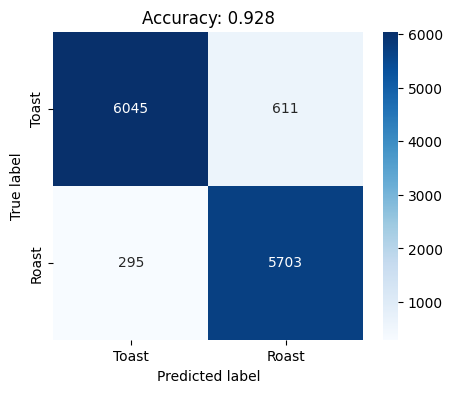

In [34]:
#### Confusion matrix and classifier report for Val

predLabs_Val = np.argmax( model.predict(padded_Val), axis=1)

cm = confusion_matrix(Labs_Val, predLabs_Val)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["Toast", "Roast"],
                     columns = ["Toast", "Roast"])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Accuracy: {0:.3f}'.format(accuracy_score(Labs_Val, predLabs_Val)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig( pathSave_main_Results+"/ConfMat_Val_KerasEmbDense__"+ExpID+".png", dpi=400 )
plt.show()

print("\n\n")
print(classification_report(Labs_Val, predLabs_Val, target_names=["Toast", "Roast"]))